# Car Dataset Preparation 

The following notebook is used to prepare the car image dataset for modelling purposes

### Imports

In [44]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio
import imgaug as ia
from os import listdir
from os.path import isfile, join
from imgaug import augmenters as iaa


### Constant Setting

In [4]:
# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
bucket_name='dataset-cars-damage'
prefix = '' #only use this if you want to have your files in a folder 
dataset_filename = 'car-damage-dataset.zip'
dataset_unpacked_dir = 'car-damage-dataset/'

### Environment Setup

In [5]:
def setup_env():
    
    role = get_execution_role()

    sess = sagemaker.Session()

    
    AWS_REGION = 'us-east-1'
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(bucket_name)

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
    return role, sess, AWS_REGION, s3,s3_bucket

role, sess,  AWS_REGION, s3, s3_bucket = setup_env()

Bucket already exists


### Load Images for Data Preparation

In [27]:
def download_and_store_images_for_prep(bucket_name, s3):
    
    manifest_train = []
    manifest_val = []
    data_dir = 'tmp_data/'
    idx = 0
    conn = boto3.client('s3')  # again assumes boto.cfg setup, assume AWS S3
    
    for file in s3_bucket.objects.all():#(Bucket=bucket_name, Prefix=data_path)['Contents']:
        path = file.key
        if ('.JPEG' in path) or ('.jpeg' in path):
            if 'validation' in path:
                folders = path.split('/')
                folder_path = 'tmp_data/'
                for i in range(0, len(folders)-1):
                    #check if folder or dir
                    folder = folders[i]
                    if '.' not in folder:
                        folder_path = folder_path + folder + '/'
                        try:
                            os.mkdir(folder_path)
                            print(folder_path)
                        except:
                            pass
                print('Adding File {}'.format(path))
                s3_bucket.download_file(
                path, data_dir+path)
    
            
download_and_store_images_for_prep(bucket_name, s3)

validation/damage-val-0001.JPEG
validation/damage-val-0002.JPEG
validation/damage-val-0003.JPEG
validation/damage-val-0004.JPEG
validation/damage-val-0005.JPEG
validation/damage-val-0006.JPEG
validation/damage-val-0007.JPEG
validation/damage-val-0008.JPEG
validation/damage-val-0009.JPEG
validation/damage-val-0010.JPEG
validation/damage-val-0011.JPEG
validation/damage-val-0012.JPEG
validation/damage-val-0013.JPEG
validation/damage-val-0014.JPEG
validation/damage-val-0015.JPEG
validation/damage-val-0016.JPEG
validation/damage-val-0017.JPEG
validation/damage-val-0018.JPEG
validation/damage-val-0019.JPEG
validation/damage-val-0020.JPEG
validation/damage-val-0021.JPEG
validation/damage-val-0022.JPEG
validation/damage-val-0023.JPEG
validation/damage-val-0024.JPEG
validation/damage-val-0025.jpeg
validation/damage-val-0026.JPEG
validation/damage-val-0027.jpeg
validation/damage-val-0028.JPEG
validation/damage-val-0029.JPEG
validation/damage-val-0030.JPEG
validation/damage-val-0031.JPEG
validati

validation/whole-val-0227.JPEG
validation/whole-val-0228.JPEG
validation/whole-val-0229.JPEG
validation/whole-val-0230.JPEG


###  Load the files for Augmentation



In [72]:
def load_files_for_augmentation():
    data_dir = 'tmp_data'
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(data_dir):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    print(len(listOfFiles))
    
    images = []
    filenames = []
    for image in listOfFiles:
        try:
            image_data = imageio.imread(image)
            images.append(image_data)
            filenames.append(image)
        except:
            print('error loading image')
    return images, filenames

images, filenames = load_files_for_augmentation()


1307


### Simple Augmentor (Test) 

Original


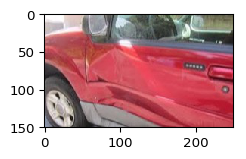

Augmented:


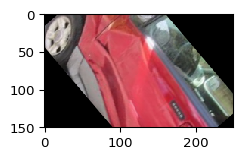

In [57]:
def augment_images(images):
    ia.seed(4)

    for image in images:

        rotate = iaa.Affine(rotate=(-125, 125))
        image_aug = rotate.augment_image(image)
        print('Original')
        ia.imshow(image)

        print("Augmented:")
        ia.imshow(image_aug)

        break
        
augment_images(images)

### Complex Augmenter

In [100]:
def complex_augmenter(images):
    # random example images

    # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
    # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
    sometimes = lambda aug: iaa.Sometimes(1, aug)

    # Define our sequence of augmentation steps that will be applied to every image
    # All augmenters with per_channel=0.5 will sample one value _per image_
    # in 50% of all cases. In all other cases they will sample new values
    # _per channel_.

    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45), # rotate by -45 to +45 degrees
                shear=(-16, 16), # shear by -16 to +16 degrees
                order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                    ]),
                    iaa.Invert(0.05, per_channel=True), # invert color channels
                    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.5, 1.5), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-4, 0),
                            first=iaa.Multiply((0.5, 1.5), per_channel=True),
                            second=iaa.LinearContrast((0.5, 2.0))
                        )
                    ]),
                    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    iaa.Grayscale(alpha=(0.0, 1.0)),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=False
            )
        ],
        random_order=False
    )
    
    images_aug = seq(images=images)
    
    return images_aug

images_aug = complex_augmenter(images)

In [111]:
def generate_augementations(images, filenames, batches = 2):
    
    augmentations =[]
    for i in range(0, batches):
        print('Generating Batch {}'.format(i))
        aug_batch = {}
        images_aug = complex_augmenter(images=images)
        print(len(images_aug))
        for j in range(0, len(images_aug)):
            filename = filenames[j].lower().replace('.jpeg','').replace('.jpg','')
            filename_aug = filename+'-augmented-'+str(i)+'.jpeg'
#             print(filename_aug)
            aug_batch[filename_aug] = images_aug[j]
#             print(j)
        augmentations.append(aug_batch)
    return augmentations

augmentations = generate_augementations(images, filenames, batches=1000)

Generating Batch 0
1307
Generating Batch 1
1307
Generating Batch 2
1307
Generating Batch 3
1307
Generating Batch 4
1307
Generating Batch 5
1307
Generating Batch 6
1307
Generating Batch 7
1307
Generating Batch 8
1307
Generating Batch 9
1307
Generating Batch 10
1307
Generating Batch 11
1307
Generating Batch 12
1307
Generating Batch 13
1307
Generating Batch 14


KeyboardInterrupt: 

In [113]:
# for k,v in augmentations[0].items():
#     print(len(k))
print(len(augmentations))

1
